# **Step 1 : Data import and preparation**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from google.colab import files

Syllableerror_score = files.upload()
dict_Syllableerror_score = next(iter(Syllableerror_score))

df = pd.read_csv(dict_Syllableerror_score)
df = df.iloc[:,1:]
df = df.dropna()
df = df.reset_index(drop=True)

print(df)


    disease  error_1  error_2  error_3  error_4
0         1        1        4        3        3
1         1        0        2        4        0
2         1        0        6        6        2
3         1        7        8        5       11
4         1        7        1        5        1
..      ...      ...      ...      ...      ...
69        0        0        1        1        1
70        0        0        0        2        1
71        0        0        0        3        2
72        0        0        0        3        1
73        0        1        0        2        1

[74 rows x 5 columns]


In [3]:
##### Dataset preparation #####

# Load your dataset (assuming df is predefined)
data = df
domain = 'disease'  #'Target variable'
features = ['error_1', 'error_2', 'error_3', 'error_4']  #'Features'
features_label = ['LBP', 'LAP', 'VP', 'MP'] #as abbv. of Labial-Placement, Lingual-Alveolar-Placement, Velo-Pharyngeal-Placement, and Mixed-Placement, respectively

# Prepare dataset
data_final = data[features + [domain]].dropna().reset_index(drop=True)

# Initialize violin plot
plt.rc("font", size=14)
sns.set(style="whitegrid")

# **Step 2 : Define cross-validation, hyperparameters, and permutation(label-shuffling) procedure**

In [4]:
##### Define cross-validation and prepare hyperparameter #####

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for regularization strength (C)
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
param_grid = {"C": C}


In [5]:
def generate_permuted_label_datasets(data_final, domain, n_perm=10000, n_per_group=37, seed=None):
    permuted_datasets = []
    rng = np.random.default_rng(seed)

    all_idx = np.array(data_final.index)

    for _ in range(n_perm):
        shuffled = rng.permutation(all_idx)

        idx0 = shuffled[:n_per_group]
        idx1 = shuffled[n_per_group:2*n_per_group]

        perm_df = data_final.loc[np.concatenate([idx0, idx1])].reset_index(drop=True)
        perm_df[domain] = [0]*n_per_group + [1]*n_per_group

        permuted_datasets.append(perm_df)

    return permuted_datasets

In [6]:
def fit_and_eval_auc_models(data, domain, features, features_label, kf, param_grid, split_seed=3):
    metrics = {}
    y = data[domain]

    ## Individual feature models
    for i, feature in enumerate(features):
        X = data[[feature]]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=split_seed, stratify=y)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        lr_L1 = LogisticRegression(max_iter=10000, solver="liblinear", penalty="l1")
        lr_L2 = LogisticRegression(max_iter=10000, solver="liblinear", penalty="l2")

        gs1 = GridSearchCV(lr_L1, param_grid, cv=kf, scoring="roc_auc")
        gs2 = GridSearchCV(lr_L2, param_grid, cv=kf, scoring="roc_auc")

        gs1.fit(X_train_scaled, y_train)
        gs2.fit(X_train_scaled, y_train)

        best = gs1.best_estimator_ if gs1.best_score_ > gs2.best_score_ else gs2.best_estimator_

        if len(np.unique(y_test)) < 2:
            auc = np.nan
        else:
            proba = best.predict_proba(X_test_scaled)[:, 1]
            auc = roc_auc_score(y_test, proba)

        metrics[f"{features_label[i]}_AUC"] = auc

    ## Combined model
    X_all = data[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y, test_size=0.3, random_state=17, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    lr_L1 = LogisticRegression(max_iter=10000, solver="saga", penalty="l1")
    lr_L2 = LogisticRegression(max_iter=10000, solver="lbfgs", penalty="l2")

    gs1 = GridSearchCV(lr_L1, param_grid, cv=kf, scoring="roc_auc")
    gs2 = GridSearchCV(lr_L2, param_grid, cv=kf, scoring="roc_auc")

    gs1.fit(X_train_scaled, y_train)
    gs2.fit(X_train_scaled, y_train)

    best = gs1.best_estimator_ if gs1.best_score_ > gs2.best_score_ else gs2.best_estimator_

    if len(np.unique(y_test)) < 2:
        auc_all = np.nan
    else:
        proba_all = best.predict_proba(X_test_scaled)[:, 1]
        auc_all = roc_auc_score(y_test, proba_all)

    metrics["Combined_AUC"] = auc_all
    return metrics

# **Step 3: Run 10,000 label permutations to generate null AUC distributions**

In [7]:
# Generate permuted-label datasets (null condition)
permuted_dfs = generate_permuted_label_datasets(
    data_final=data_final,
    domain=domain,
    n_perm=10000,
    n_per_group=37,
    seed=0)

print(f"Generated {len(permuted_dfs)} permuted-label datasets.")
display(permuted_dfs[0].head())

# Evaluate AUC for each permuted dataset (null AUCs)
null_auc_rows = []

for perm_df in permuted_dfs:
    row = fit_and_eval_auc_models(
        data=perm_df,
        domain=domain,
        features=features,
        features_label=features_label,
        kf=kf,
        param_grid=param_grid,
        split_seed=990)
    null_auc_rows.append(row)

null_metrics_df = pd.DataFrame(null_auc_rows)
auc_cols = [f"{lab}_AUC" for lab in features_label] + ["Combined_AUC"]
null_auc_df = null_metrics_df[auc_cols].copy()
null_auc_df.columns = features_label + ["Combined"]

display(null_auc_df.head())

# Summarize null AUC distributions (mean + 95% CI)
summary_df = pd.DataFrame({
    "Mean": null_auc_df.mean(skipna=True),
    "95% CI Lower": null_auc_df.quantile(0.025),
    "95% CI Upper": null_auc_df.quantile(0.975),})

display(summary_df)


Generated 10000 permuted-label datasets.


,error_1,error_2,error_3,error_4,disease
0,6,1,1,1,0
1,3,4,4,4,0
2,0,0,4,1,0
3,4,5,7,5,0
4,1,0,3,3,0


,LBP,LAP,VP,MP,Combined
0,0.500000,0.405303,0.768939,0.500000,0.757576
1,0.397727,0.500000,0.500000,0.564394,0.356061
2,0.500000,0.681818,0.772727,0.594697,0.609848
3,0.500000,0.500000,0.541667,0.390152,0.500000
4,0.659091,0.500000,0.378788,0.500000,0.412879


,Mean,95% CI Lower,95% CI Upper
LBP,0.499727,0.303030,0.693277
LAP,0.500517,0.295455,0.696970
VP,0.501800,0.299242,0.700758
MP,0.499117,0.333333,0.666667
Combined,0.501505,0.280303,0.715909


# **Step 4: Run original (non-permuted) AUC analysis and compute one-sided permutation p-values**

In [10]:
#Analyze original AUC score for each individual model and combined model
observed_metrics = fit_and_eval_auc_models(
    data=data_final,
    domain=domain,
    features=features,
    features_label=features_label,
    kf=kf,
    param_grid=param_grid,
    split_seed=3)

print("Observed AUCs (original labels):")
print(observed_metrics)

#Compute one-sided p-values (null AUCs >= original AUC)
auc_columns = [f"{lab}_AUC" for lab in features_label] + ["Combined_AUC"]

p_values_auc = {}
for col in auc_columns:
    if col not in null_metrics_df.columns:
        continue

    null_vals = null_metrics_df[col].dropna()
    obs_val = observed_metrics.get(col, np.nan)

    if null_vals.empty or pd.isna(obs_val):
        p_values_auc[col] = np.nan
    else:
        p_values_auc[col] = float((null_vals >= obs_val).mean())

p_values_auc_df = pd.DataFrame.from_dict(p_values_auc, orient="index", columns=["Permutation_p_value"]).sort_values("Permutation_p_value")
print(p_values_auc_df)


Observed AUCs (original labels):
{'LBP_AUC': 0.7575757575757576, 'LAP_AUC': 0.8636363636363638, 'VP_AUC': 0.7159090909090909, 'MP_AUC': 0.6477272727272727, 'Combined_AUC': 0.8560606060606061}
              Permutation_p_value
LAP_AUC                    0.0003
Combined_AUC               0.0006
LBP_AUC                    0.0062
VP_AUC                     0.0192
MP_AUC                     0.0381


# **Step 6: Plot null AUC distributions (histogram / boxplot / violin)**

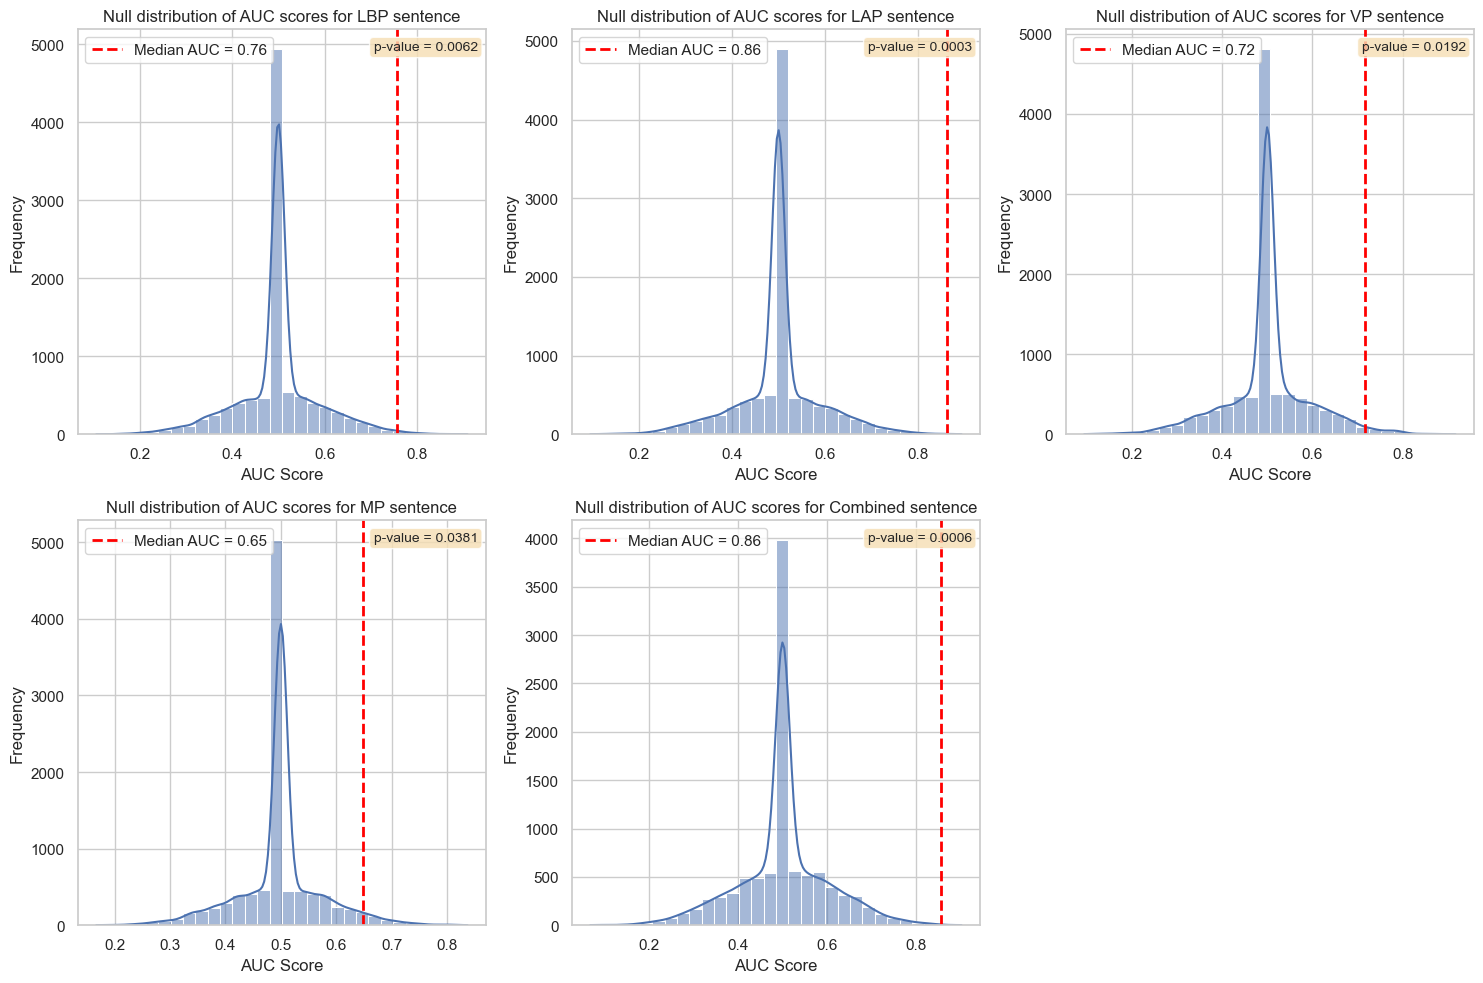

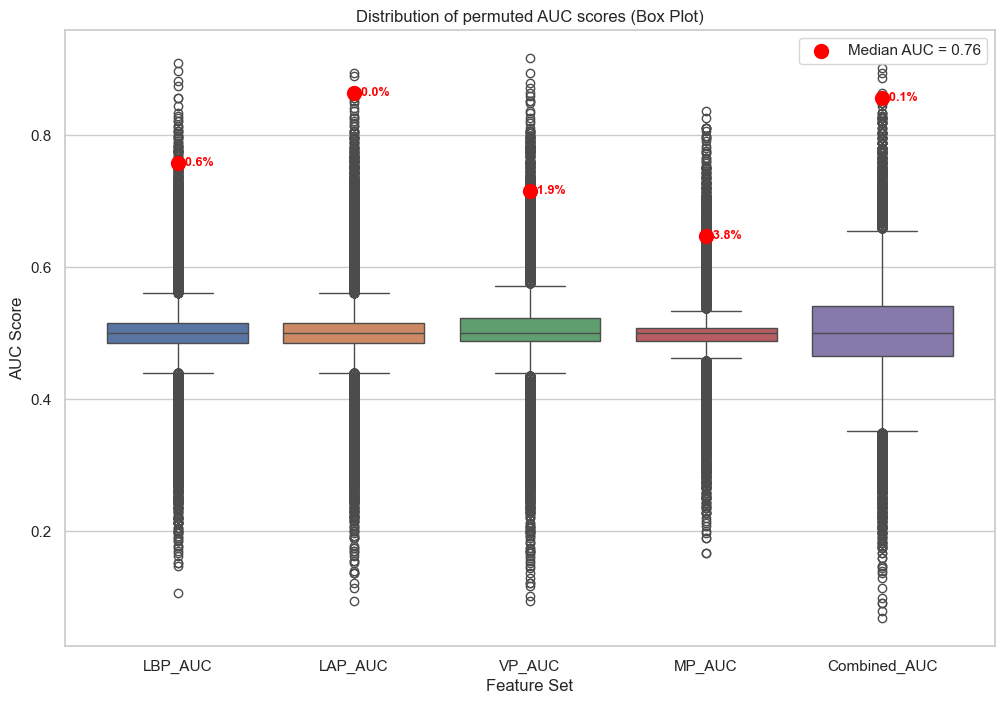

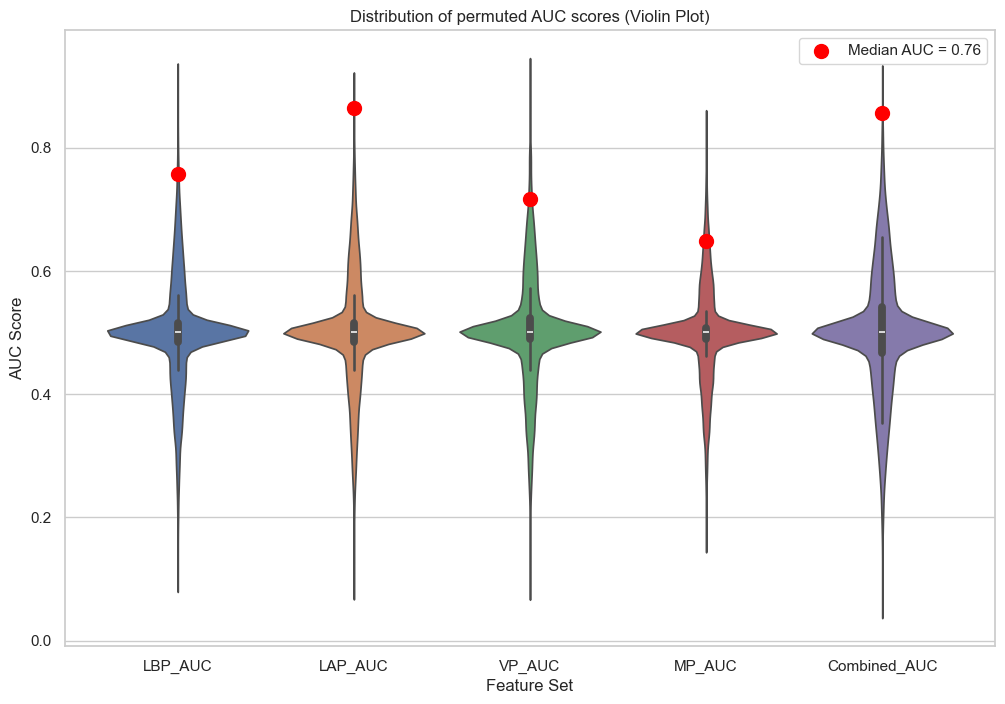

In [12]:
metric_columns = auc_columns

#Plotting Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(metric_columns):
    if col not in null_metrics_df.columns:
        continue

    plt.subplot(2, 3, i + 1)
    ax = plt.gca()

    sns.histplot(null_metrics_df[col].dropna(), kde=True, bins=30, ax=ax)

    obs_val = observed_metrics.get(col, np.nan)
    feature_name = col.split("_")[0]

    if not pd.isna(obs_val):
        plt.axvline(
            obs_val, color="red", linestyle="--", linewidth=2,
            label=f"Median AUC = {obs_val:.2f}"
        )

        p_val = p_values_auc.get(col, np.nan)
        if not pd.isna(p_val):
            plt.text(
                0.98, 0.97, f"p-value = {p_val:.4f}",
                transform=ax.transAxes, ha="right", va="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
                fontsize=10
            )

        plt.title(f"Null distribution of AUC scores for {feature_name} sentence")
        plt.xlabel("AUC Score")
        plt.ylabel("Frequency")
        plt.legend(loc="upper left")
    else:
        plt.title(f"Null distribution of AUC scores: {feature_name}\nObserved: NaN")
        plt.xlabel("AUC Score")
        plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#Plotting Box plot
plt.figure(figsize=(12, 8))
plot_df = null_metrics_df[metric_columns].dropna(how="all")
ax = plt.gca()
sns.boxplot(data=plot_df, ax=ax)

for i, col in enumerate(metric_columns):
    obs_val = observed_metrics.get(col, np.nan)
    if pd.isna(obs_val):
        continue

    plt.scatter(
        i, obs_val, color="red", s=100, zorder=5,
        label=f"Median AUC = {obs_val:.2f}" if i == 0 else ""
    )

    null_vals = null_metrics_df[col].dropna()
    prop_above = float((null_vals >= obs_val).mean()) if len(null_vals) else np.nan

    if not np.isnan(prop_above):
        plt.text(
            i, obs_val, f"  {prop_above:.1%}",
            va="center", ha="left", fontsize=9,
            color="red", fontweight="bold"
        )

plt.title("Distribution of permuted AUC scores (Box Plot)")
plt.ylabel("AUC Score")
plt.xlabel("Feature Set")
if not pd.isna(observed_metrics.get(metric_columns[0], np.nan)):
    plt.legend()
plt.show()


#Plotting Violin plot
plt.figure(figsize=(12, 8))
ax = plt.gca()
sns.violinplot(data=plot_df, ax=ax)

for i, col in enumerate(metric_columns):
    obs_val = observed_metrics.get(col, np.nan)
    if pd.isna(obs_val):
        continue

    plt.scatter(
        i, obs_val, color="red", s=100, zorder=5,
        label=f"Median AUC = {obs_val:.2f}" if i == 0 else ""
    )

plt.title("Distribution of permuted AUC scores (Violin Plot)")
plt.ylabel("AUC Score")
plt.xlabel("Feature Set")
if not pd.isna(observed_metrics.get(metric_columns[0], np.nan)):
    plt.legend()
plt.show()